# PETSc performance breakdown

This notebook runs timing breakdown using PETSc events:

- Warmup + timed solve per approach and mesh size
- Event times: SNESSolve, KSPSolve, PCSetUp, PCApply, Jacobian/Residual evals, MatAssembly
- Outputs a CSV of results

You can tweak the mesh sizes and approaches as needed.

Highly inspired by this work: https://github.com/thomasgibson/tabula-rasa

In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

from pathlib import Path
from typing import List
import matplotlib.pyplot as plt

from perphil.experiments.iterative_bench import Approach
from perphil.experiments.petsc_profiling import run_perf_sweep, save_perf_csv

RESULTS_PATH = Path("results-conforming-2d/petsc_profiling")

## Parameters

In [2]:
# mesh_sizes: List[int] = [4, 8, 16, 32, 64]  # this is the one for final results
# mesh_sizes: List[int] = [4, 8, 16, 32]
# mesh_sizes: List[int] = [5, 10, 15, 20]
mesh_sizes: List[int] = [5, 10, 15, 20]
approaches: List[Approach] = [
    Approach.PLAIN_GMRES,
    Approach.GMRES_ILU,
    Approach.SS_GMRES,
    Approach.SS_GMRES_ILU,
    Approach.PICARD_MUMPS,
    # Approach.MONOLITHIC_MUMPS,
]
extra_events: List[str] = []

## Run and collect

In [3]:
df = run_perf_sweep(mesh_sizes, approaches, repeats=3, backend="events")
df.sort_values(["nx", "approach"])

[perf] nx=5 GMRES: iters=14, time_total=5.814e-02s, KSPSolve=3.349e-04s, PCApply=1.150e-05s, flops_total=9.814e+05 (backend=events, repeats=3)
[perf] nx=5 GMRES + ILU PC: iters=5, time_total=2.700e-02s, KSPSolve=2.194e-04s, PCApply=2.160e-05s, flops_total=7.805e+05 (backend=events, repeats=3)
[perf] nx=5 Scale-Splitting GMRES: iters=4, time_total=8.721e-02s, KSPSolve=3.788e-03s, PCApply=3.584e-03s, flops_total=8.620e+05 (backend=events, repeats=3)
[perf] nx=5 Scale-Splitting GMRES + ILU PC: iters=4, time_total=1.069e-01s, KSPSolve=1.034e-03s, PCApply=9.220e-04s, flops_total=1.546e+06 (backend=events, repeats=3)
[perf] nx=5 Scaling-Splitting Picard with MUMPS: iters=27, time_total=1.790e+00s, KSPSolve=0.000e+00s, PCApply=0.000e+00s, flops_total=1.042e+08 (backend=events, repeats=3)
[perf] nx=10 GMRES: iters=93, time_total=2.908e-02s, KSPSolve=1.999e-03s, PCApply=8.290e-05s, flops_total=1.736e+07 (backend=events, repeats=3)
[perf] nx=10 GMRES + ILU PC: iters=8, time_total=6.580e-02s, KSP

,approach,nx,ny,dofs,num_cells,iterations,residual,metadata,time_total,time_total_repeats,...,mflops_MatAssemblyEnd,flops_MatMult,mflops_MatMult,flops_KSPSolve,mflops_KSPSolve,flops_MatAssemblyBegin,mflops_MatAssemblyBegin,flops_total,mem_rss_peak_kb,mem_rss_delta_kb
0,GMRES,5,5,72,25,14,0.000131,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.058139,0.174417,...,0.0,82992.0,2433.782991,189552.0,565.995820,0.0,0.0,9.814320e+05,284120.0,0.0
1,GMRES + ILU PC,5,5,72,25,5,0.002552,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.027002,0.081005,...,0.0,29640.0,2333.858268,84585.0,385.528715,0.0,0.0,7.805220e+05,284120.0,0.0
2,Scale-Splitting GMRES,5,5,72,25,4,0.000410,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.087213,0.261638,...,0.0,30852.0,1182.068966,69387.0,18.317098,0.0,0.0,8.619840e+05,288016.0,1536.0
3,Scale-Splitting GMRES + ILU PC,5,5,72,25,4,0.000410,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.106935,0.320806,...,0.0,95112.0,1216.265985,275637.0,266.521949,0.0,0.0,1.545648e+06,290192.0,1536.0
4,Scaling-Splitting Picard with MUMPS,5,5,72,25,27,0.000121,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",1.789866,5.369599,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.041510e+08,292240.0,128.0
5,GMRES,10,10,242,100,93,0.000477,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.029083,0.087249,...,0.0,2144448.0,2866.142743,6564924.0,3283.447034,0.0,0.0,1.736029e+07,292880.0,256.0
6,GMRES + ILU PC,10,10,242,100,8,0.008084,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.065798,0.197395,...,0.0,178704.0,2190.000000,516825.0,1288.840399,0.0,0.0,3.663630e+06,293392.0,256.0
7,Scale-Splitting GMRES,10,10,242,100,4,0.008155,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.089625,0.268876,...,0.0,116367.0,1074.487535,304887.0,63.965886,0.0,0.0,3.559365e+06,293392.0,0.0
8,Scale-Splitting GMRES + ILU PC,10,10,242,100,4,0.008155,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.094730,0.284190,...,0.0,516189.0,1076.739675,1640685.0,1037.161009,0.0,0.0,7.960749e+06,293392.0,0.0
9,Scaling-Splitting Picard with MUMPS,10,10,242,100,92,0.000770,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",5.838671,17.516014,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.559906e+09,293392.0,0.0


## Save CSV (optional)

In [4]:
save_perf_csv(df, RESULTS_PATH / "petsc_perf_breakdown.csv")
df.head()

,approach,nx,ny,dofs,num_cells,iterations,residual,metadata,time_total,time_total_repeats,...,mflops_MatAssemblyEnd,flops_MatMult,mflops_MatMult,flops_KSPSolve,mflops_KSPSolve,flops_MatAssemblyBegin,mflops_MatAssemblyBegin,flops_total,mem_rss_peak_kb,mem_rss_delta_kb
0,GMRES,5,5,72,25,14,0.000131,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.058139,0.174417,...,0.0,82992.0,2433.782991,189552.0,565.995820,0.0,0.0,981432.0,284120.0,0.0
1,GMRES + ILU PC,5,5,72,25,5,0.002552,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.027002,0.081005,...,0.0,29640.0,2333.858268,84585.0,385.528715,0.0,0.0,780522.0,284120.0,0.0
2,Scale-Splitting GMRES,5,5,72,25,4,0.000410,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.087213,0.261638,...,0.0,30852.0,1182.068966,69387.0,18.317098,0.0,0.0,861984.0,288016.0,1536.0
3,Scale-Splitting GMRES + ILU PC,5,5,72,25,4,0.000410,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.106935,0.320806,...,0.0,95112.0,1216.265985,275637.0,266.521949,0.0,0.0,1545648.0,290192.0,1536.0
4,Scaling-Splitting Picard with MUMPS,5,5,72,25,27,0.000121,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",1.789866,5.369599,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,104151012.0,292240.0,128.0


## Plot: Total Time (average wall time), Total Iterations, and FLOPS.

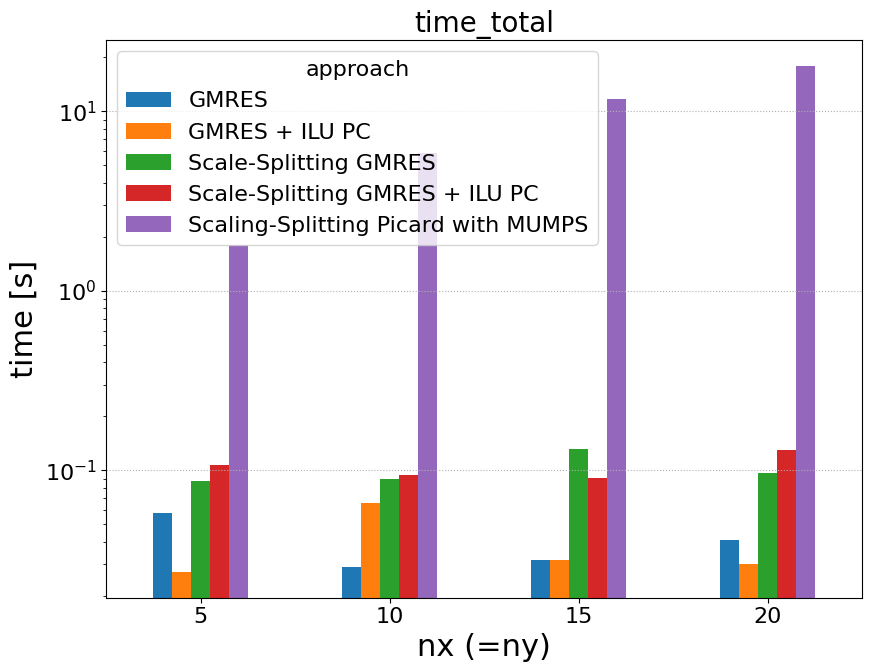

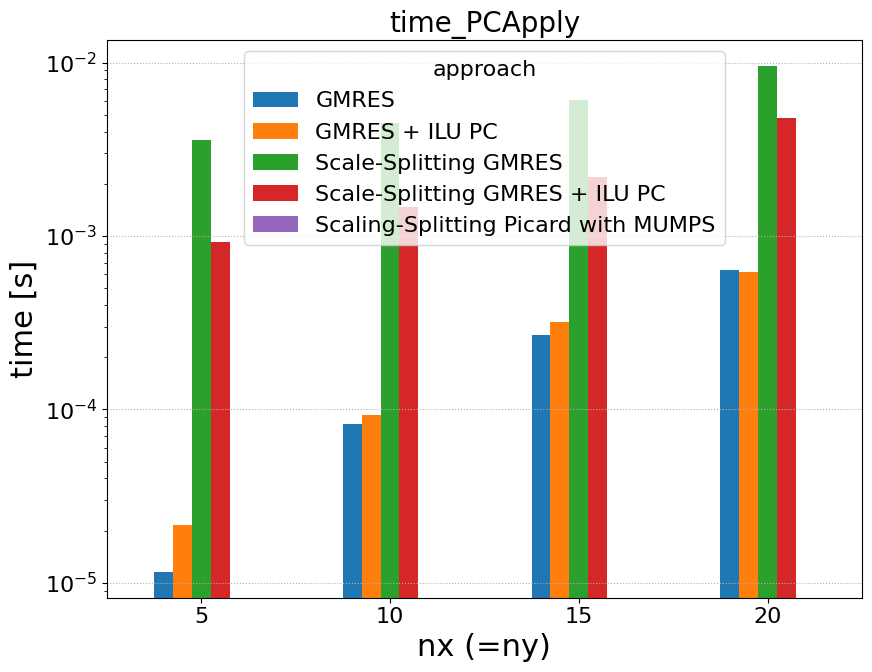

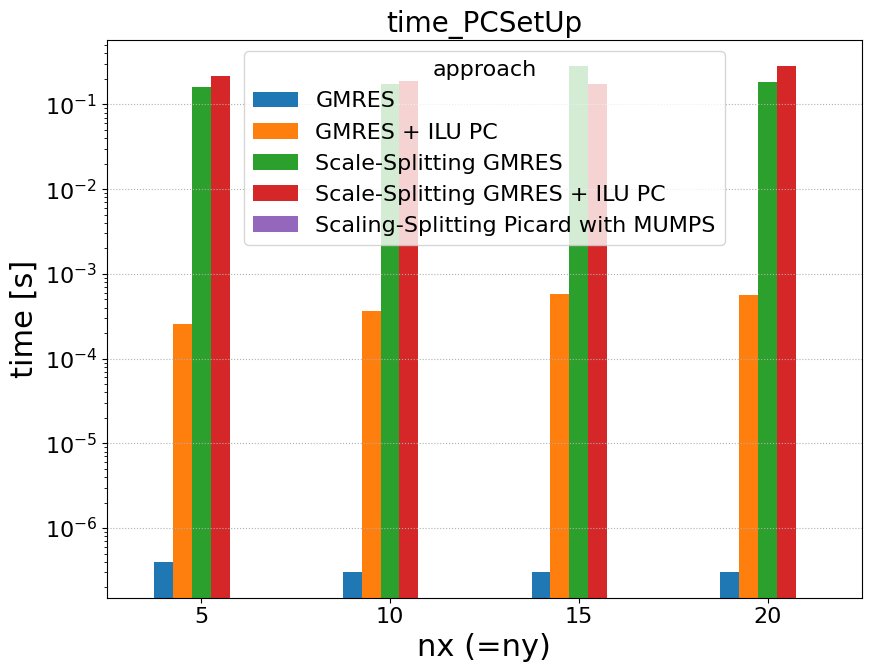

In [5]:
for metric in ("time_total", "time_PCApply", "time_PCSetUp"):
    pivot = df.pivot(index="nx", columns="approach", values=metric).sort_index()
    ax = pivot.plot(kind="bar", figsize=(9, 7), title=metric, logy=True, rot=0)
    ax.set_xlabel("nx (=ny)")
    ax.set_ylabel("time [s]")
    ax.grid(axis="y", ls=":")
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / f"petsc_{metric}_bar.png")
    plt.show()

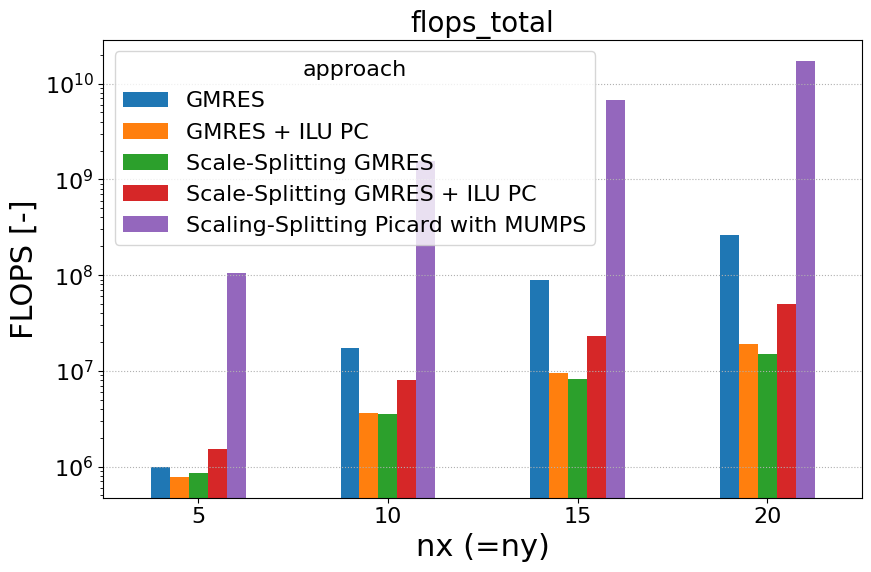

In [6]:
pivot = df.pivot(index="nx", columns="approach", values="flops_total").sort_index()
ax = pivot.plot(kind="bar", figsize=(9, 6), title="flops_total", logy=True, rot=0)
ax.set_xlabel("nx (=ny)")
ax.set_ylabel("FLOPS [-]")
ax.grid(axis="y", ls=":")
plt.tight_layout()
plt.savefig(RESULTS_PATH / "petsc_flops_bar.png")
plt.show()

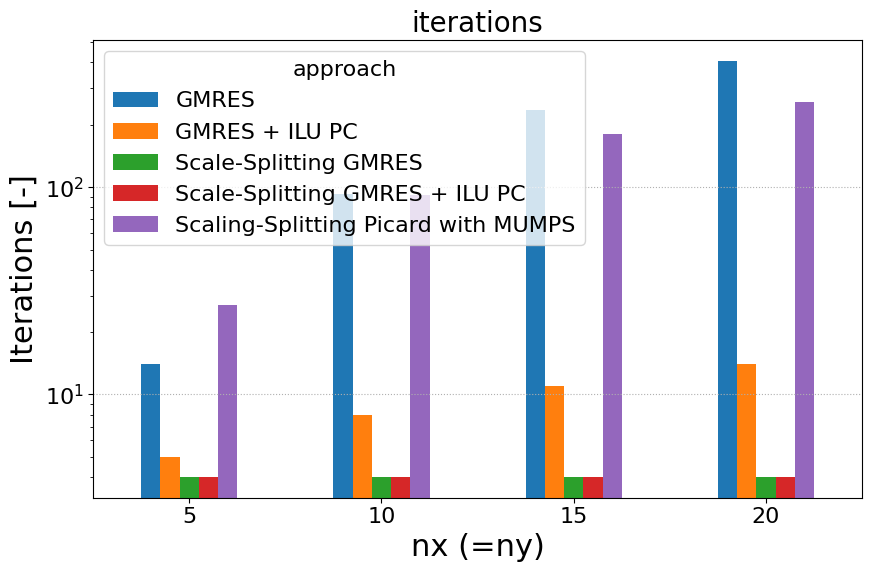

In [7]:
pivot = df.pivot(index="nx", columns="approach", values="iterations").sort_index()
ax = pivot.plot(kind="bar", figsize=(9, 6), title="iterations", logy=True, rot=0)
ax.set_xlabel("nx (=ny)")
ax.set_ylabel("Iterations [-]")
ax.grid(axis="y", ls=":")
plt.tight_layout()
plt.savefig(RESULTS_PATH / "petsc_iterations_bar.png")
plt.show()

In [8]:
df

,approach,nx,ny,dofs,num_cells,iterations,residual,metadata,time_total,time_total_repeats,...,mflops_MatAssemblyEnd,flops_MatMult,mflops_MatMult,flops_KSPSolve,mflops_KSPSolve,flops_MatAssemblyBegin,mflops_MatAssemblyBegin,flops_total,mem_rss_peak_kb,mem_rss_delta_kb
0,GMRES,5,5,72,25,14,0.000131,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.058139,0.174417,...,0.0,82992.0,2433.782991,189552.0,565.995820,0.0,0.0,9.814320e+05,284120.0,0.0
1,GMRES + ILU PC,5,5,72,25,5,0.002552,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.027002,0.081005,...,0.0,29640.0,2333.858268,84585.0,385.528715,0.0,0.0,7.805220e+05,284120.0,0.0
2,Scale-Splitting GMRES,5,5,72,25,4,0.000410,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.087213,0.261638,...,0.0,30852.0,1182.068966,69387.0,18.317098,0.0,0.0,8.619840e+05,288016.0,1536.0
3,Scale-Splitting GMRES + ILU PC,5,5,72,25,4,0.000410,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.106935,0.320806,...,0.0,95112.0,1216.265985,275637.0,266.521949,0.0,0.0,1.545648e+06,290192.0,1536.0
4,Scaling-Splitting Picard with MUMPS,5,5,72,25,27,0.000121,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",1.789866,5.369599,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.041510e+08,292240.0,128.0
5,GMRES,10,10,242,100,93,0.000477,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.029083,0.087249,...,0.0,2144448.0,2866.142743,6564924.0,3283.447034,0.0,0.0,1.736029e+07,292880.0,256.0
6,GMRES + ILU PC,10,10,242,100,8,0.008084,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.065798,0.197395,...,0.0,178704.0,2190.000000,516825.0,1288.840399,0.0,0.0,3.663630e+06,293392.0,256.0
7,Scale-Splitting GMRES,10,10,242,100,4,0.008155,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.089625,0.268876,...,0.0,116367.0,1074.487535,304887.0,63.965886,0.0,0.0,3.559365e+06,293392.0,0.0
8,Scale-Splitting GMRES + ILU PC,10,10,242,100,4,0.008155,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.094730,0.284190,...,0.0,516189.0,1076.739675,1640685.0,1037.161009,0.0,0.0,7.960749e+06,293392.0,0.0
9,Scaling-Splitting Picard with MUMPS,10,10,242,100,92,0.000770,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",5.838671,17.516014,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.559906e+09,293392.0,0.0
